### Here we transform the NetCDF file into standard lists for further analyses 
#### We regrid the spatial resolution onto 2°×2°
#### Historical O${_3}$ simulations 1850-2014

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import iris
from eofs.iris import Eof

#### Prescribe the key parameters: 
##### i) target years for analysis (e.g. Y = 5 for five most recent years 2010-2014)
##### ii) ideal spatial resolutions (e.g. 180×90 grids)
###### These parameters are prescribed arbitrarily

In [2]:
Y = 5
lon = 180
lat = 90

#### Define the 1°×1° new spatial resolution for regridding (centred coordinates)

In [3]:
res_lon = 360/lon
res_lat = 180/lat
sample_points = [('longitude', np.linspace(0+res_lon/2, 360-res_lon/2, lon)),
                 ('latitude',  np.linspace(-90+res_lat/2, 90-res_lat/2, lat))]

In [4]:
sample_points

[('longitude',
  array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
          23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
          45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
          67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
          89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
         111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
         133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
         155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
         177., 179., 181., 183., 185., 187., 189., 191., 193., 195., 197.,
         199., 201., 203., 205., 207., 209., 211., 213., 215., 217., 219.,
         221., 223., 225., 227., 229., 231., 233., 235., 237., 239., 241.,
         243., 245., 247., 249., 251., 253., 255., 257., 259., 261., 263.,
         265., 267., 269., 271., 273., 275., 277., 279., 281., 283., 285.,
         2

#### Define the longitude-latitude-temporal sequence list

In [5]:
t = Y*12 ## Y years correspond to 12Y months 

lon_range = np.linspace(0+res_lon/2, 360-res_lon/2, lon)
lat_range = np.linspace(-90+res_lat/2, 90-res_lat/2, lat) 
t_range   = np.linspace(1, t, t) 
lat_mesh, t_mesh, lon_mesh = np.meshgrid(lat_range, t_range, lon_range) 

t_grid   = t_mesh.reshape(t*lon*lat, 1)
lon_grid = lon_mesh.reshape(t*lon*lat, 1)
lat_grid = lat_mesh.reshape(t*lon*lat, 1)

dataset = pd.DataFrame(lon_grid, columns = {'longitude'})
dataset['latitude'] = lat_grid
dataset['t'] = t_grid
dataset['loc'] = dataset['longitude']*1000+dataset['latitude']
dataset

,longitude,latitude,t,loc
0,1.0,-89.0,1.0,911.0
1,3.0,-89.0,1.0,2911.0
2,5.0,-89.0,1.0,4911.0
3,7.0,-89.0,1.0,6911.0
4,9.0,-89.0,1.0,8911.0
...,...,...,...,...
971995,351.0,89.0,60.0,351089.0
971996,353.0,89.0,60.0,353089.0
971997,355.0,89.0,60.0,355089.0
971998,357.0,89.0,60.0,357089.0


#### 1.1. Import surface/ambient O${_3}$

In [6]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/o3_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'o3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
o3 = values.reshape(t*lon*lat,1)
dataset['o3'] = o3

#### 1.2. Import surface/ambient O${_3}$ production rate 

In [7]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/o3prod_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'o3prod')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
o3prod = values.reshape(t*lon*lat,1)
dataset['o3prod'] = o3prod

#### 1.3. Import surface/ambient O${_3}$ loss rate

In [8]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/o3loss_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'o3loss')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
o3loss = values.reshape(t*lon*lat,1)
dataset['o3loss'] = o3loss

#### 2.1. Import total NO${_X}$ emission 

In [9]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/eminox_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc', 'eminox')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
nox = values.reshape(t*lon*lat,1)
dataset['eminox'] = nox

#### 2.2. Import total VOC emission

In [10]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/emivoc_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc', 'emivoc')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
voc = values.reshape(t*lon*lat,1)
dataset['emivoc'] = voc

#### 3.1. Import near-surface air temperature

In [11]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/tas_Amon_MIROC6_historical_r1i1p1f1_gn_195001-201412.nc', 'tas')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
tas = values.reshape(t*lon*lat,1)
dataset['tas'] = tas

#### 3.2. Import ambient air humidity

In [12]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/hus_Amon_MIROC6_historical_r1i1p1f1_gn_201001-201412.nc', 'hus')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:,:]
data = data.collapsed('air_pressure', iris.analysis.MAX)
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
hus = values.reshape(t*lon*lat,1)
dataset['hus'] = hus

#### 3.3. Import aerosol optical depth at 550 nm

In [13]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/abs550aer_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'abs550aer')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
aod = values.reshape(t*lon*lat,1)
dataset['aod'] = aod

#### 3.4. Import planetary boundary layer height

In [14]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/bldep_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'bldep')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
pbl = values.reshape(t*lon*lat,1)
dataset['bldep'] = pbl

#### 3.5. Import eastward wind speed

In [15]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/ua_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'ua')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
ua = values.reshape(t*lon*lat,1)
dataset['ua'] = ua

#### 3.6. Import northward wind speed

In [16]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/va_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'va')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
va = values.reshape(t*lon*lat,1)
dataset['va'] = va

#### 4.1. Import NO${_2}$ photolysis rate

In [17]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/jno2_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'jno2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
jno2 = values.reshape(t*lon*lat,1)
dataset['jno2'] = jno2

#### 4.2. Import O${_3}$→O(${^1}$D) photolysis rate

In [18]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/photo1d_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'photo1d')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
jo3 = values.reshape(t*lon*lat,1)
dataset['photo1d'] = jo3

#### 4.3. Import CH${_4}$ reaction loss rate

#### The chemistry scheme of MIROC-ES2H seems closer to MRI-ESM2-0

In [19]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/lossch4_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'lossch4')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
lossch4 = values.reshape(t*lon*lat,1)
dataset['lossch4'] = lossch4

#### 4.4. Import CO reaction loss rate

In [20]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/lossco_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'lossco')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
lossco = values.reshape(t*lon*lat,1)
dataset['lossco'] = lossco

#### 5.1. Import NO${_2}$ concentration

In [21]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/no2_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'no2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
no2 = values.reshape(t*lon*lat,1)
dataset['no2'] = no2

#### 5.2. Import NO concentration

In [22]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/no_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'no')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
no = values.reshape(t*lon*lat,1)
dataset['no'] = no

#### 5.3. Import OH radical concentration

In [23]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/oh_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'oh')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
oh = values.reshape(t*lon*lat,1)
dataset['oh'] = oh

#### 5.4. Import H${_2}$O concentration

In [24]:
data = iris.load_cube('/Volumes/Database/CMIP6/NCAR/CESM2-WACCM-FV2/historical/h2o_AERmon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_200001-201412.nc', 'h2o')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,69,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
h2o = values.reshape(t*lon*lat,1)
dataset['h2o'] = h2o

#### 5.5. Import PAN reservoir concentration

In [25]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/pan_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'pan')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
pan = values.reshape(t*lon*lat,1)
dataset['pan'] = pan

#### 5.6. Import HNO${_3}$ reservoir concentration

In [26]:
data = iris.load_cube('/Volumes/Database/CMIP6/MIROC/historical/hno3_AERmon_MIROC-ES2H_historical_r1i1p4f2_gn_185001-201412.nc', 'hno3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
hno3 = values.reshape(t*lon*lat,1)
dataset['hno3'] = hno3

#### We should convert 0-360° into 180°W-180°E scheme

In [27]:
dataset_pt1 = dataset[dataset['longitude'] < 180]
dataset_pt2 = dataset[dataset['longitude'] >= 180]
dataset_pt2['longitude'] = dataset_pt2['longitude']-360
dataset_adj = dataset_pt1.append(dataset_pt2)
dataset_adj

,longitude,latitude,t,loc,o3,o3prod,o3loss,eminox,emivoc,tas,...,jno2,photo1d,lossch4,lossco,no2,no,oh,h2o,pan,hno3
0,1.0,-89.0,1.0,911.0,3.210802e-08,6.627869e-08,5.410460e-08,0.000000e+00,0.000000e+00,258.682770,...,0.008017,3.505344,1.736006e-14,5.558714e-14,1.090357e-11,1.121056e-11,7.070591e-15,0.000583,3.265840e-11,4.002974e-11
1,3.0,-89.0,1.0,2911.0,3.206121e-08,6.609950e-08,5.364701e-08,0.000000e+00,0.000000e+00,258.659332,...,0.008012,3.508763,1.720428e-14,5.538285e-14,1.090357e-11,1.121056e-11,7.067733e-15,0.000581,3.263911e-11,3.985141e-11
2,5.0,-89.0,1.0,4911.0,3.199147e-08,6.612568e-08,5.327078e-08,0.000000e+00,0.000000e+00,258.608765,...,0.008027,3.512601,1.696959e-14,5.492787e-14,1.090357e-11,1.129953e-11,7.032951e-15,0.000578,3.261983e-11,3.949474e-11
3,7.0,-89.0,1.0,6911.0,3.199147e-08,6.612568e-08,5.327078e-08,0.000000e+00,0.000000e+00,258.587799,...,0.008027,3.512601,1.696959e-14,5.492787e-14,1.090357e-11,1.129953e-11,7.032951e-15,0.000576,3.261983e-11,3.949474e-11
4,9.0,-89.0,1.0,8911.0,3.188926e-08,6.609906e-08,5.277926e-08,0.000000e+00,0.000000e+00,258.560638,...,0.008047,3.516484,1.687757e-14,5.491911e-14,1.011642e-11,1.138850e-11,7.056861e-15,0.000573,3.258127e-11,3.931640e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971995,-9.0,89.0,60.0,351089.0,1.034151e-08,1.000847e-16,1.000847e-16,7.690745e-14,1.949230e-16,249.975708,...,0.000000,0.000000,1.372514e-16,9.333173e-16,2.711804e-11,1.895191e-22,2.310619e-17,0.000496,1.507145e-10,3.101139e-11
971996,-7.0,89.0,60.0,353089.0,1.032512e-08,1.000936e-16,1.000936e-16,4.297552e-15,1.089221e-17,250.003052,...,0.000000,0.000000,1.150641e-16,8.020406e-16,2.199388e-11,1.895191e-22,1.962808e-17,0.000495,1.510293e-10,3.168828e-11
971997,-5.0,89.0,60.0,355089.0,1.032512e-08,1.000936e-16,1.000936e-16,4.297552e-15,1.089221e-17,250.030396,...,0.000000,0.000000,1.150641e-16,8.020406e-16,2.199388e-11,1.895191e-22,1.962808e-17,0.000493,1.510293e-10,3.168828e-11
971998,-3.0,89.0,60.0,357089.0,1.030782e-08,1.000984e-16,1.000984e-16,1.650221e-14,4.182508e-17,250.089828,...,0.000000,0.000000,1.259960e-16,8.726543e-16,2.199388e-11,1.895191e-22,2.142068e-17,0.000492,1.513703e-10,3.236517e-11


#### Calculate the kinetic rates

In [28]:
dataset_adj['k_no_ho2']   = 3.30*10**(-12)*np.exp(270/dataset_adj['tas'])
dataset_adj['k_no_ch3o2'] = 2.30*10**(-12)*np.exp(360/dataset_adj['tas'])
dataset_adj['k_o1d_h2o']  = 1.63*10**(-10)*np.exp(60/dataset_adj['tas'])
dataset_adj['k_o3_ho2']   = 2.03*10**(-16)*(dataset_adj['tas']/300)**4.57*np.exp(693/dataset_adj['tas'])
dataset_adj['k_o3_oh']    = 1.70*10**(-12)*np.exp(-940/dataset_adj['tas'])

#### Calculate the procedural auxilliary variables 
##### where K1's are aggressive approach to use as many associated variables as possible 
##### and K2's are conservative approach to only use variables that we trust the credibility 

In [29]:
dataset_adj['K1_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no'] * dataset_adj['lossco']
dataset_adj['K1_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no'] * dataset_adj['lossch4']
dataset_adj['K1_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['photo1d'] * dataset_adj['o3'] * dataset_adj['hus']
dataset_adj['K1_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K1_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3'] * dataset_adj['lossco']

In [30]:
dataset_adj['K2_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no']
dataset_adj['K2_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no']
dataset_adj['K2_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['hus']
dataset_adj['K2_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K2_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3']

In [31]:
dataset_adj.to_csv('/Volumes/Database/Research/C7 Multivariate analysis/MIROC-ES2H_diag_2014(0318).csv', index = False)

### Map the variables to ensure correct gridding

(-90.0, 90.0)

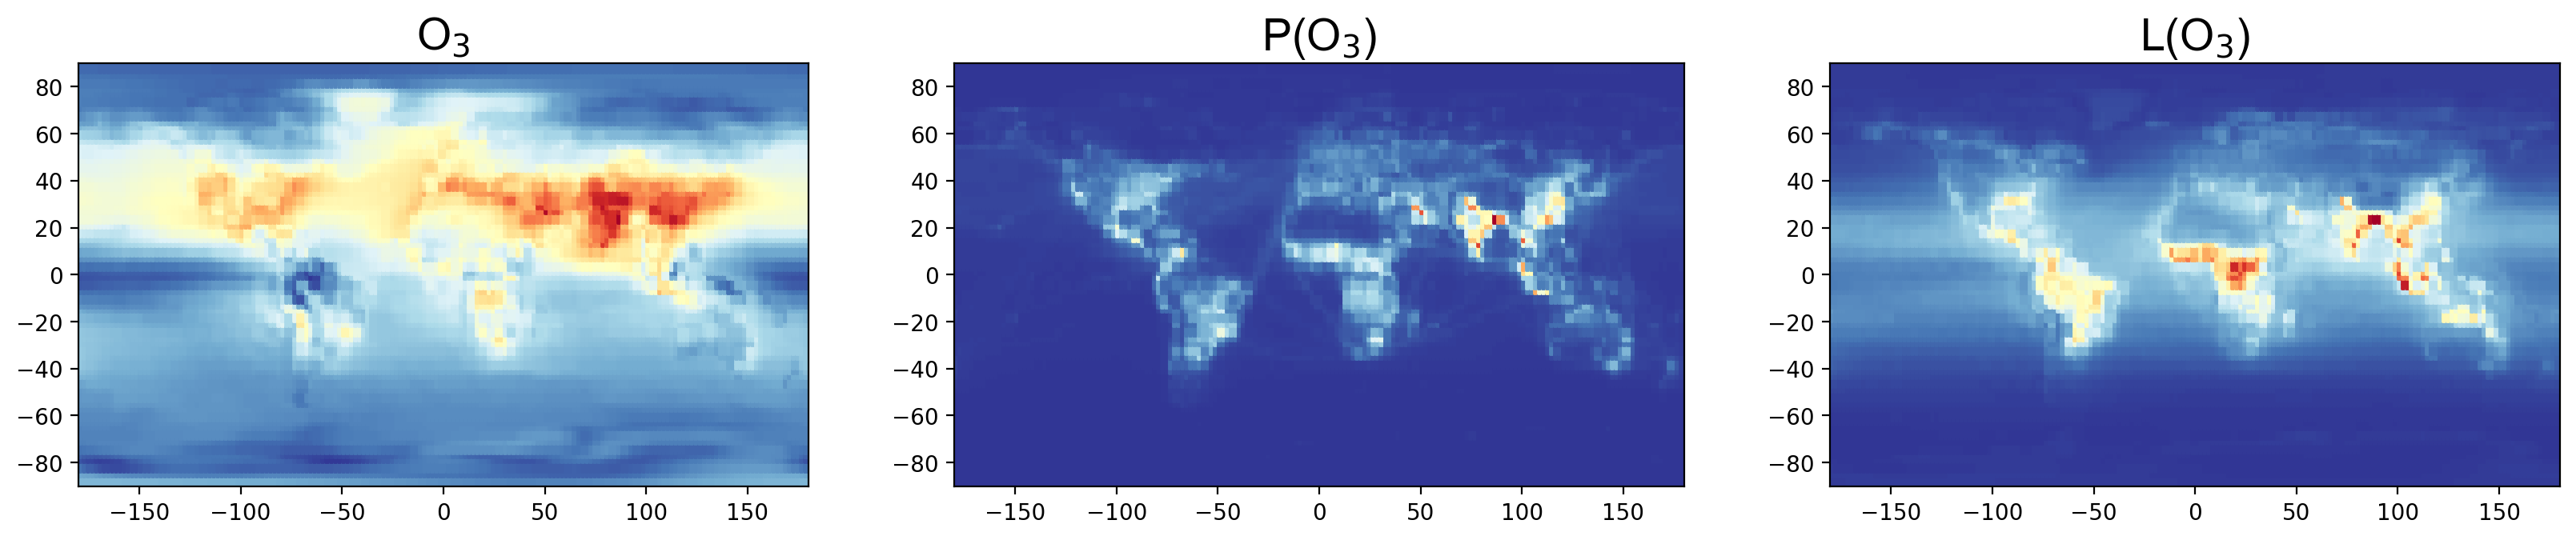

In [32]:
dataset_map = dataset_adj.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('O${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('P(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3prod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('L(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3loss'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

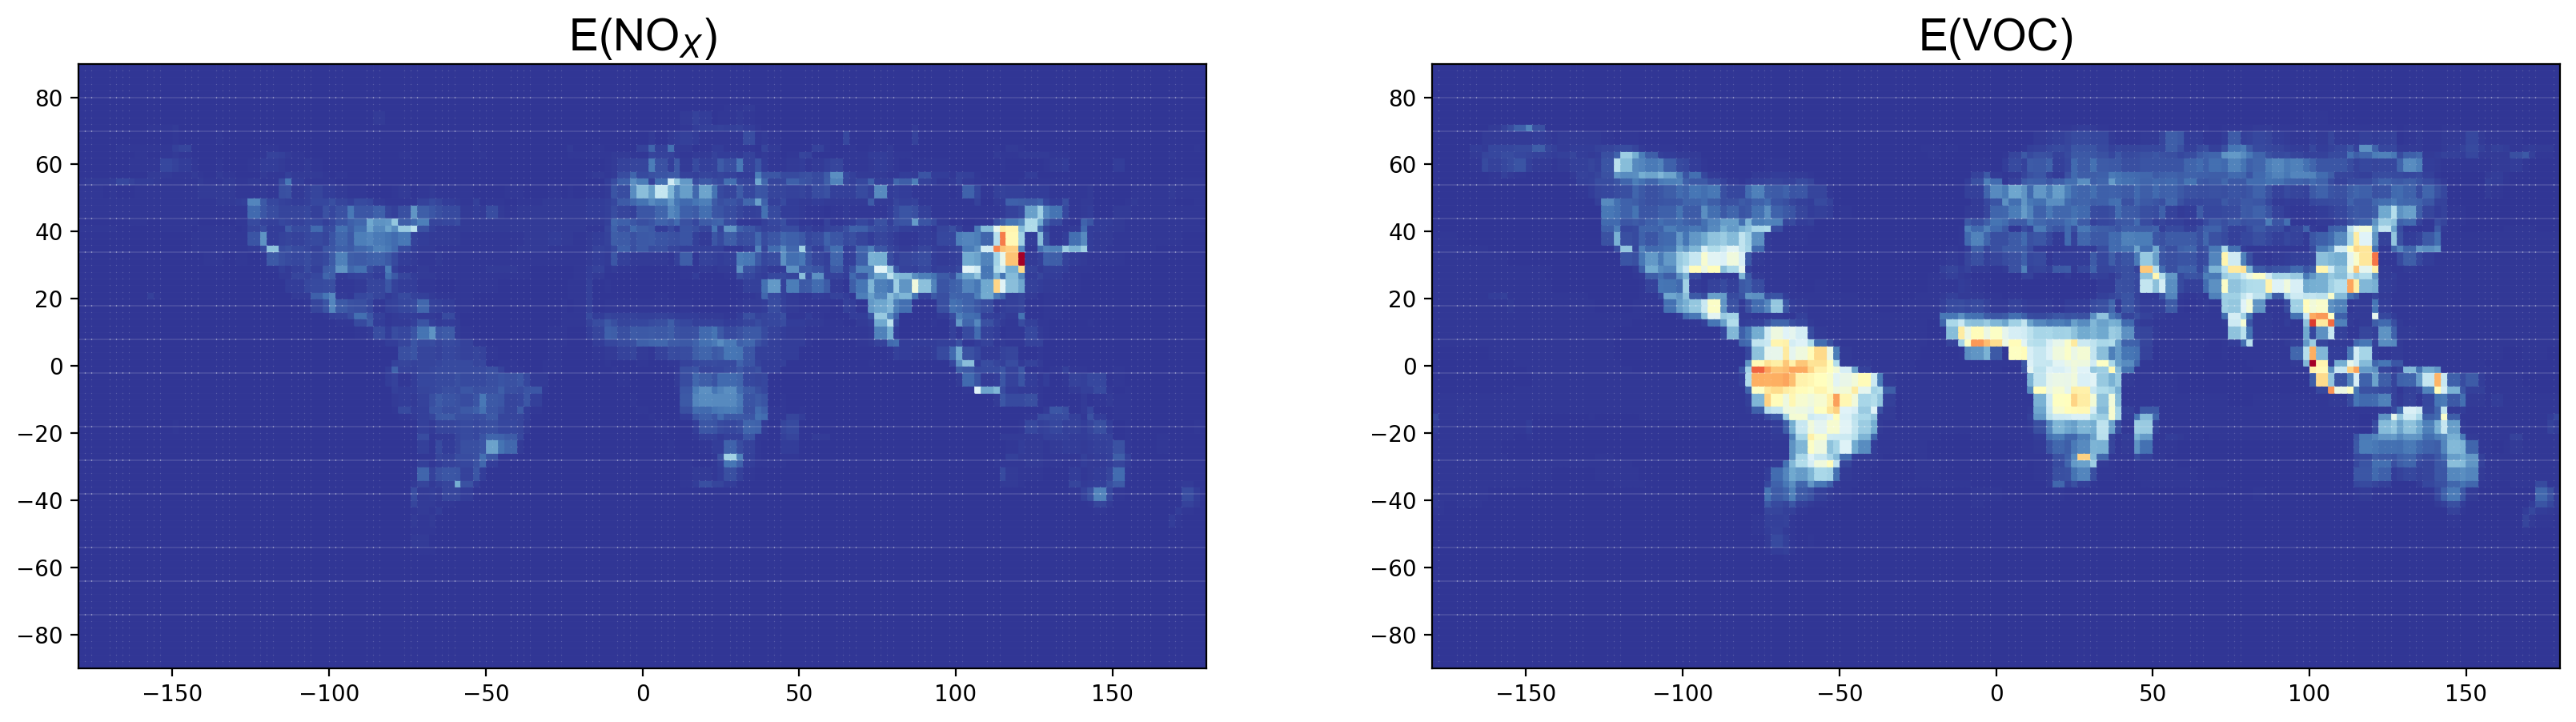

In [33]:
plt.figure(num=None, figsize=(20, 5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,2,1)
plt.title('E(NO${_X}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['eminox'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,2,2)
plt.title('E(VOC)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['emivoc'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

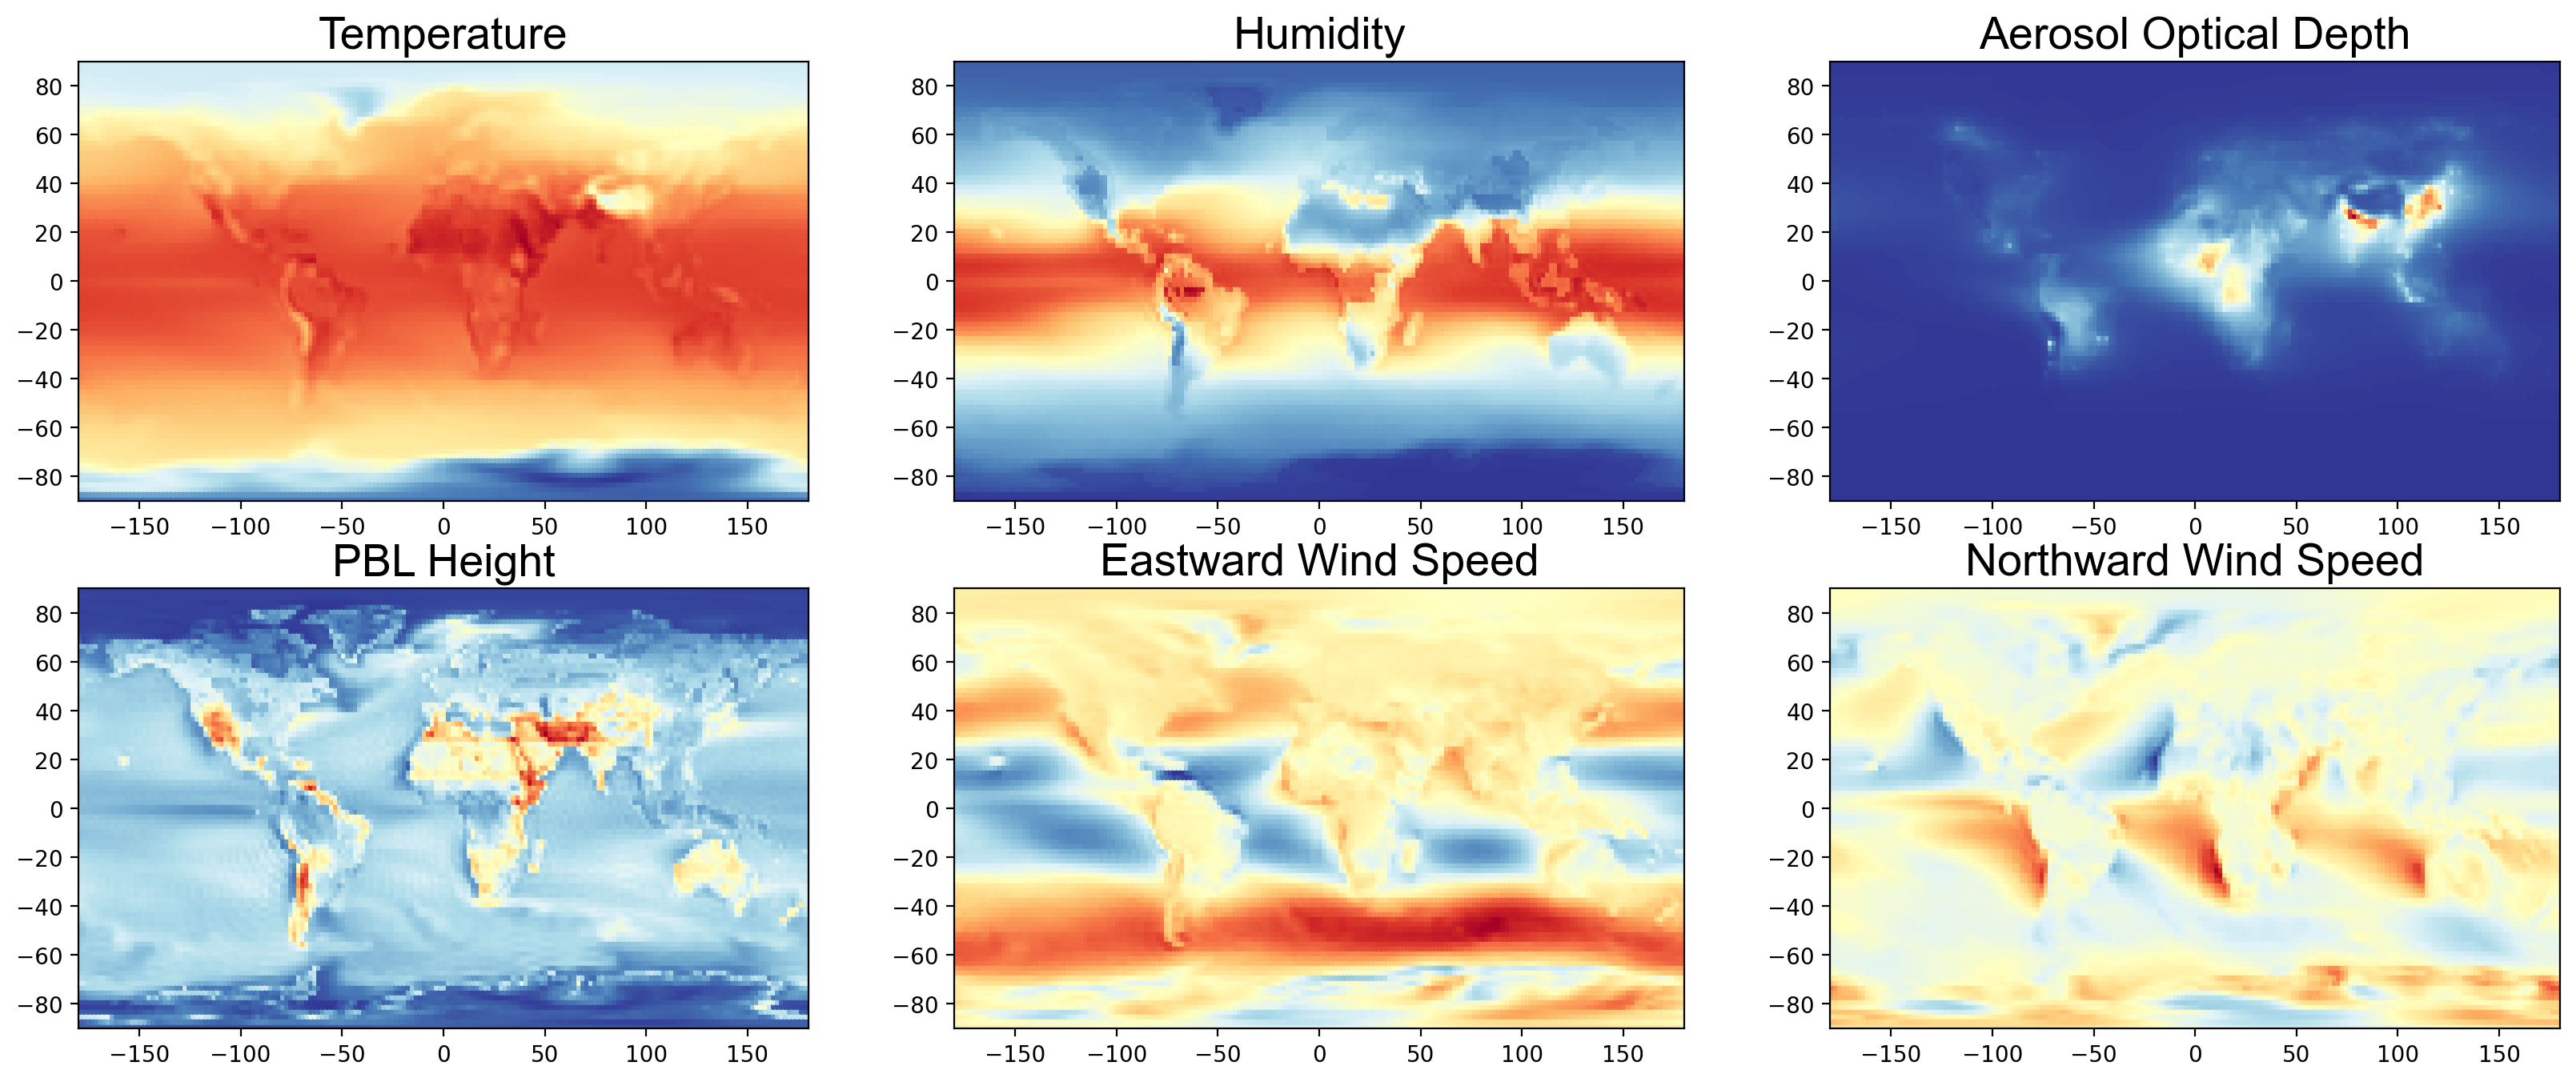

In [34]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('Temperature', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['tas'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('Humidity', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['hus'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('Aerosol Optical Depth', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['aod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('PBL Height', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['bldep'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('Eastward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ua'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('Northward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['va'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

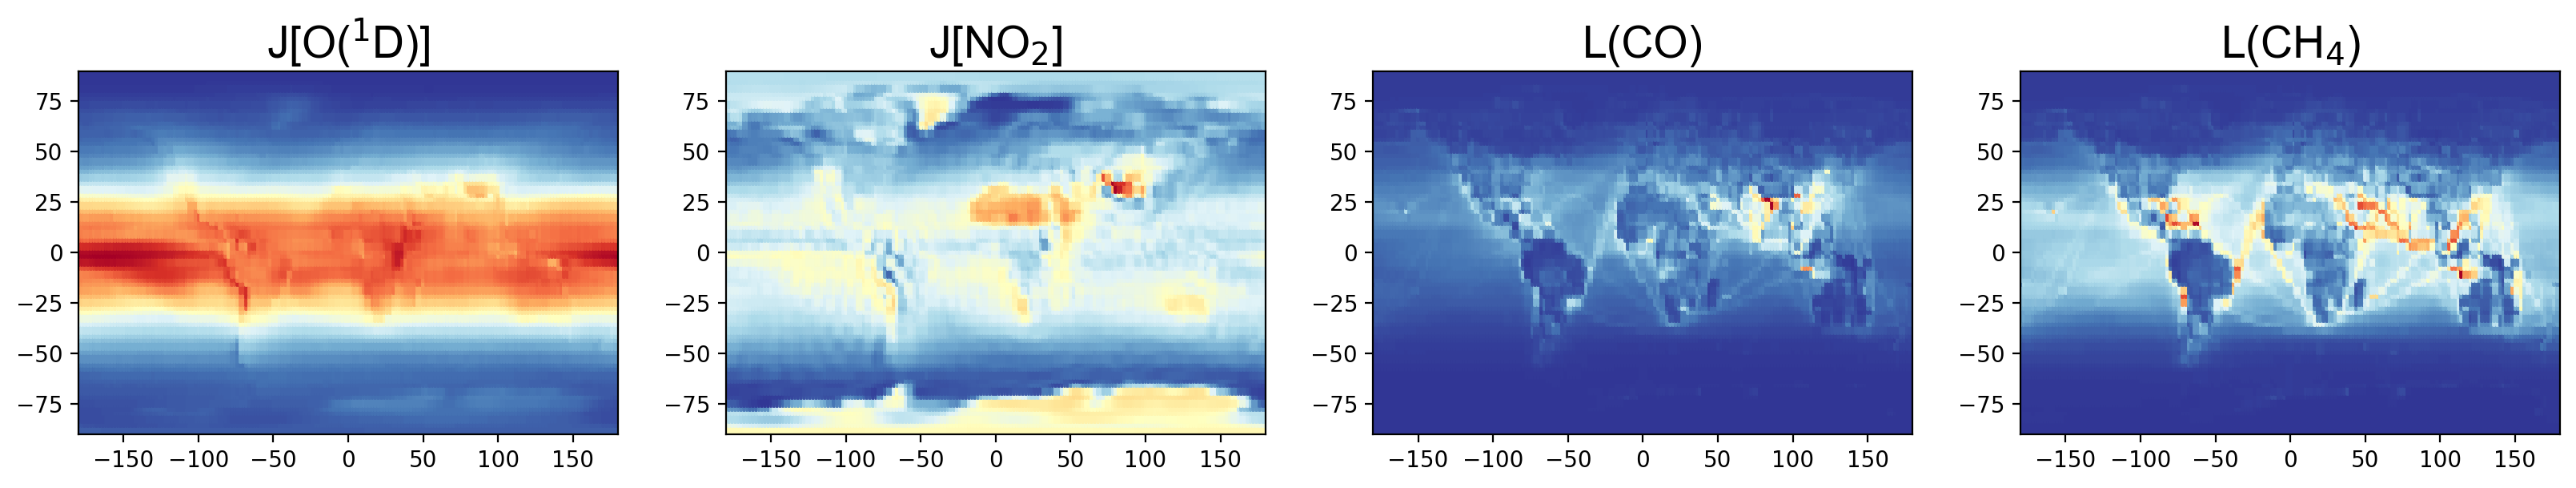

In [35]:
plt.figure(num=None, figsize=(20, 3), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(1,4,1)
plt.title('J[O(${^1}$D)]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['photo1d'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,2)
plt.title('J[NO${_2}$]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['jno2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,3)
plt.title('L(CO)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossco'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,4)
plt.title('L(CH${_4}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossch4'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

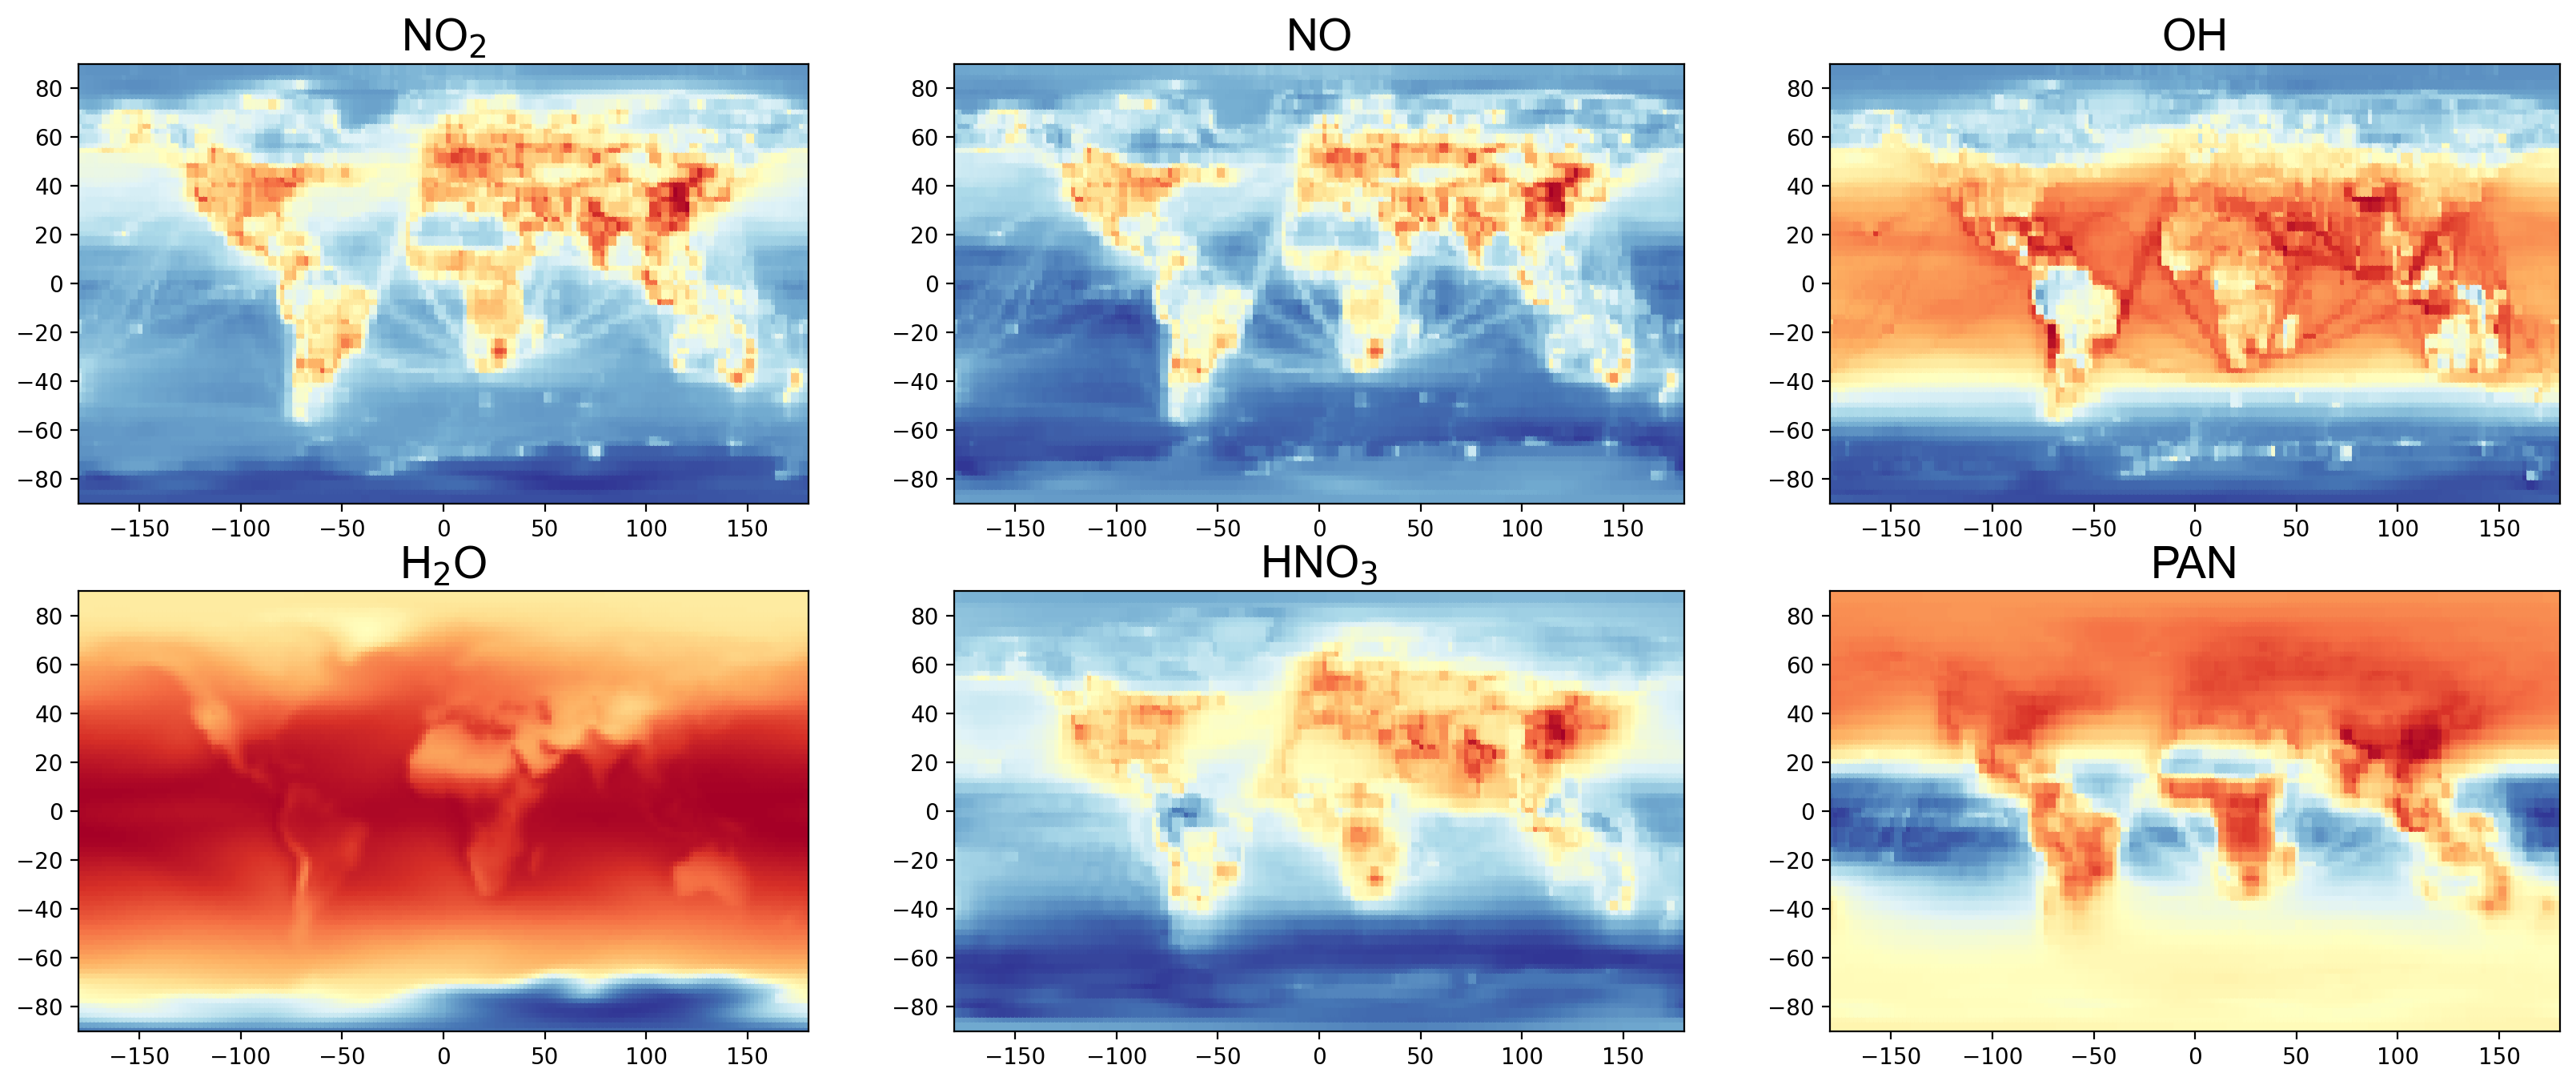

In [36]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('NO${_2}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('NO', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('OH', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['oh'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('H${_2}$O', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['h2o'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('HNO${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['hno3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('PAN', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['pan'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

#### We should now check whether each variable has been correctly extracted without any erroneous values (e.g. negative concentrations), and the sample sizes are all year×12×lon×lat. 

In [37]:
dataset_adj['eminox'].describe()

count    9.720000e+05
mean     2.633854e-12
std      9.283495e-12
min      0.000000e+00
25%      9.285304e-15
50%      1.422184e-13
75%      1.214905e-12
max      3.274905e-10
Name: eminox, dtype: float64

In [38]:
dataset_adj['emivoc'].describe()

count    9.720000e+05
mean     5.569847e-13
std      1.646182e-12
min      0.000000e+00
25%      5.472032e-15
50%      4.816773e-14
75%      1.057212e-13
max      1.175499e-10
Name: emivoc, dtype: float64

In [39]:
dataset_adj['o3'].describe()

count    9.720000e+05
mean     2.382303e-08
std      1.005974e-08
min      3.638916e-09
25%      1.617698e-08
50%      2.181137e-08
75%      2.934296e-08
max      8.750051e-08
Name: o3, dtype: float64

In [40]:
dataset_adj['o3prod'].describe()

count    9.720000e+05
mean     1.980411e-07
std      4.151489e-07
min      7.095344e-17
25%      1.340857e-08
50%      5.384534e-08
75%      1.812774e-07
max      8.482353e-06
Name: o3prod, dtype: float64

In [41]:
dataset_adj['o3loss'].describe()

count    9.720000e+05
mean     9.073108e-08
std      1.098003e-07
min      7.427860e-17
25%      1.028151e-08
50%      5.088110e-08
75%      1.350132e-07
max      1.791077e-06
Name: o3loss, dtype: float64

In [42]:
dataset_adj['tas'].describe()

count    972000.000000
mean        280.880066
std          20.231499
min         202.017395
25%         271.970665
50%         285.188919
75%         297.088356
max         325.693329
Name: tas, dtype: float64

In [43]:
dataset_adj['hus'].describe()

count    972000.000000
mean          0.007164
std           0.005531
min           0.000065
25%           0.002623
50%           0.005663
75%           0.011462
max           0.022557
Name: hus, dtype: float64

In [44]:
dataset_adj['aod'].describe()

count    972000.000000
mean          0.001670
std           0.003432
min           0.000023
25%           0.000174
50%           0.000477
75%           0.001556
max           0.123658
Name: aod, dtype: float64

In [45]:
dataset_adj['bldep'].describe()

count    972000.000000
mean        791.927063
std         397.785339
min          80.514694
25%         513.162949
50%         781.283264
75%         998.721176
max        4242.433594
Name: bldep, dtype: float64

In [46]:
dataset_adj['ua'].describe()

count    972000.000000
mean         -0.008649
std           3.771748
min         -13.021621
25%          -1.965310
50%          -0.033443
75%           1.774294
max          14.281774
Name: ua, dtype: float64

In [47]:
dataset_adj['va'].describe()

count    972000.000000
mean          0.134192
std           2.304163
min         -15.298646
25%          -1.150566
50%           0.033645
75%           1.329312
max          16.027498
Name: va, dtype: float64

In [48]:
dataset_adj['jno2'].describe()

count    972000.000000
mean          0.002021
std           0.001479
min           0.000000
25%           0.001003
50%           0.002081
75%           0.002634
max           0.009336
Name: jno2, dtype: float64

In [49]:
dataset_adj['photo1d'].describe()

count    972000.000000
mean          4.692092
std           4.299253
min           0.000000
25%           0.564752
50%           3.549229
75%           8.568036
max          18.119125
Name: photo1d, dtype: float64

In [50]:
dataset_adj['no2'].describe()

count    9.720000e+05
mean     3.745902e-10
std      1.506122e-09
min      3.473499e-13
25%      1.439526e-11
50%      3.712341e-11
75%      1.720169e-10
max      7.262763e-08
Name: no2, dtype: float64

In [51]:
dataset_adj['no'].describe()

count    9.720000e+05
mean     2.863013e-11
std      1.267351e-10
min      1.602012e-22
25%      1.687365e-12
50%      4.593383e-12
75%      1.491324e-11
max      6.143321e-09
Name: no, dtype: float64

In [52]:
dataset_adj['oh'].describe()

count    9.720000e+05
mean     4.224684e-14
std      4.873779e-14
min      5.572052e-18
25%      3.658785e-15
50%      2.113084e-14
75%      7.253126e-14
max      6.930095e-13
Name: oh, dtype: float64

In [53]:
dataset_adj['h2o'].describe()

count    972000.000000
mean          0.007513
std           0.006069
min           0.000009
25%           0.002476
50%           0.005777
75%           0.012529
max           0.022753
Name: h2o, dtype: float64

In [54]:
dataset_adj['hno3'].describe()

count    9.720000e+05
mean     2.054640e-10
std      5.859845e-10
min      9.800584e-13
25%      1.274445e-11
50%      4.539606e-11
75%      1.471802e-10
max      1.900322e-08
Name: hno3, dtype: float64

In [55]:
dataset_adj['pan'].describe()

count    9.720000e+05
mean     1.137647e-10
std      1.409451e-10
min      1.699383e-13
25%      2.026679e-11
50%      4.257961e-11
75%      1.900157e-10
max      1.944568e-09
Name: pan, dtype: float64

In [56]:
dataset_adj['lossco'].describe()

count    9.720000e+05
mean     1.070817e-12
std      1.443055e-12
min      9.035755e-17
25%      7.518780e-14
50%      5.404818e-13
75%      1.555037e-12
max      2.840667e-11
Name: lossco, dtype: float64

In [57]:
dataset_adj['lossch4'].describe()

count    9.720000e+05
mean     4.518014e-13
std      5.504884e-13
min      8.543480e-18
25%      2.105053e-14
50%      1.898832e-13
75%      7.955618e-13
max      4.462325e-12
Name: lossch4, dtype: float64

#### We should then check the scale of the kinetic rate coefficients with the IUPAC suggested values. 

##### The preferred value as 8.5×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [58]:
dataset_adj['k_no_ho2'].median()

8.505077254772186e-12

##### The preferred value as 7.7×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [59]:
dataset_adj['k_no_ch3o2'].median()

8.127312290668486e-12

##### The preferred value as 2.14×10$^{–10}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [60]:
dataset_adj['k_o1d_h2o'].median()

2.0116733288764953e-10

##### The preferred value as 2.0×10$^{–15}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [61]:
dataset_adj['k_o3_ho2'].median()

1.829489368548766e-15

##### The preferred value as 7.3×10$^{–14}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [62]:
dataset_adj['k_o3_oh'].median()

6.294887252151966e-14